# Multiclass Classification with MobileNet

In [1]:
# import packages
import os
import cv2
import glob
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report
from mlxtend.plotting import plot_confusion_matrix

# deep learning
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications import *
from tensorflow.keras.metrics import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K

print(f'Tensorflow version : {tf.__version__}')
print(f'Keras version : {tf.keras.__version__}')

Tensorflow version : 2.2.0
Keras version : 2.3.0-tf


# Preprocessing Data

## Training Data

In [2]:
data = Path('../input/covidpreprocesseddata/train_224x224-20200626T124445Z-001/train_224x224/')
os.listdir(data)

['Normal', 'Covid', 'Others']

In [3]:
for class_ in os.listdir(data):
    print(f'Number of train-val images in {class_}: {len(os.listdir(os.path.join(data, class_)))}')

Number of train-val images in Normal: 695
Number of train-val images in Covid: 695
Number of train-val images in Others: 611


In [4]:
# Paths to respective folders
normal = data / 'Normal'
covid = data / 'Covid'
others = data / 'Others'

# image files in respective dir
covid_cases = covid.glob('*.png')
normal_cases = normal.glob('*.png')
others_cases = others.glob('*.png')

train_data = []

for img in normal_cases:
    train_data.append((str(img), 'Normal'))
    
for img in covid_cases:
    train_data.append((str(img), 'Covid'))
    
for img in others_cases:
    train_data.append((str(img), 'Others'))

# making train_data dataframe    
train_data = pd.DataFrame(train_data, columns=['path', 'label'], index=None)
train_data

,path,label
0,../input/covidpreprocesseddata/train_224x224-2...,Normal
1,../input/covidpreprocesseddata/train_224x224-2...,Normal
2,../input/covidpreprocesseddata/train_224x224-2...,Normal
3,../input/covidpreprocesseddata/train_224x224-2...,Normal
4,../input/covidpreprocesseddata/train_224x224-2...,Normal
...,...,...
1996,../input/covidpreprocesseddata/train_224x224-2...,Others
1997,../input/covidpreprocesseddata/train_224x224-2...,Others
1998,../input/covidpreprocesseddata/train_224x224-2...,Others
1999,../input/covidpreprocesseddata/train_224x224-2...,Others


## Testing Data

In [5]:
test_data = Path('../input/covidpreprocesseddata/test-20200626T124450Z-001/test/')
os.listdir(test_data)

['Normal', 'Covid', 'Others']

In [6]:
for class_ in os.listdir(test_data):
    print(f'Number of test images in {class_}: {len(os.listdir(os.path.join(test_data, class_)))}')

Number of test images in Normal: 100
Number of test images in Covid: 100
Number of test images in Others: 100


In [7]:
# Preparing test data

normal_test = test_data / 'Normal'
covid_test = test_data / 'Covid'
others_test = test_data / 'Others'

covid_cases_test = covid_test.glob('*.png')
normal_cases_test = normal_test.glob('*.png')
others_cases_test = others_test.glob('*.png')

test_data = []

for img in normal_cases_test:
    test_data.append((str(img), 'Normal'))
    
for img in covid_cases_test:
    test_data.append((str(img), 'Covid'))
    
for img in others_cases_test:
    test_data.append((str(img), 'Others'))
    
# test_data dataframe    
test_data = pd.DataFrame(test_data, columns=['path', 'label'], index=None)
test_data

,path,label
0,../input/covidpreprocesseddata/test-20200626T1...,Normal
1,../input/covidpreprocesseddata/test-20200626T1...,Normal
2,../input/covidpreprocesseddata/test-20200626T1...,Normal
3,../input/covidpreprocesseddata/test-20200626T1...,Normal
4,../input/covidpreprocesseddata/test-20200626T1...,Normal
...,...,...
295,../input/covidpreprocesseddata/test-20200626T1...,Others
296,../input/covidpreprocesseddata/test-20200626T1...,Others
297,../input/covidpreprocesseddata/test-20200626T1...,Others
298,../input/covidpreprocesseddata/test-20200626T1...,Others


## Train-Validation Split

In [8]:
# train-validation split
train, validation = train_test_split(train_data,
                                    test_size=0.2,
                                    random_state=2020,
                                    stratify=train_data['label'])

# Hyperparameters

In [9]:
IMAGE_WIDTH, IMAGE_HEIGTH = 224, 224
BATCH_SIZE = 32

INPUT_TENSOR = (224, 224, 3)
OPT = Adam(learning_rate=1e-3)
LOSS = 'categorical_crossentropy'
FOLDS = 5
EPOCHS = 150

# Data Generator

In [10]:
# train data generator
datagen_ = ImageDataGenerator(rescale=1./255,
                            zoom_range=0.2,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.2,
                             rotation_range=5)
# test data generator
test_ = ImageDataGenerator(rescale=1./255)

In [11]:
train_gen = datagen_.flow_from_dataframe(train,
                                     x_col='path',
                                     y_col='label',
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     target_size=(IMAGE_HEIGTH, IMAGE_WIDTH),
                                     class_mode='categorical')

validation_gen = datagen_.flow_from_dataframe(validation,
                                     x_col='path',
                                     y_col='label',
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     target_size=(IMAGE_HEIGTH, IMAGE_WIDTH),
                                     class_mode='categorical')

test_gen = test_.flow_from_dataframe(test_data,
                                     x_col='path',
                                     y_col='label',
                                     batch_size=BATCH_SIZE,
                                     shuffle=False,
                                     target_size=(IMAGE_HEIGTH, IMAGE_WIDTH),
                                     class_mode='categorical')

Found 1600 validated image filenames belonging to 3 classes.
Found 401 validated image filenames belonging to 3 classes.
Found 300 validated image filenames belonging to 3 classes.


# Model: MobileNet

In [12]:
base_model = NASNetMobile(input_shape=INPUT_TENSOR, weights='imagenet', include_top=False)

model_input = base_model.output
global_avg = GlobalAveragePooling2D()(model_input)
dense_1 = Dense(512, activation='relu')(global_avg)
final = Dense(3, activation='softmax')(dense_1)

model = Model(inputs=base_model.input, outputs=final)
model.summary()

19996672/19993432 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           stem_bn1[0][0]                   
_____________________________

__________________________________________________________________________________________________
normal_add_5_9 (Add)            (None, 7, 7, 176)    0           separable_conv_2_bn_normal_left5_
                                                                 normal_bn_1_9[0][0]              
__________________________________________________________________________________________________
normal_concat_9 (Concatenate)   (None, 7, 7, 1056)   0           adjust_bn_9[0][0]                
                                                                 normal_add_1_9[0][0]             
                                                                 normal_add_2_9[0][0]             
                                                                 normal_add_3_9[0][0]             
                                                                 normal_add_4_9[0][0]             
                                                                 normal_add_5_9[0][0]             
__________

In [13]:
for index, layer in enumerate(model.layers):
    print(index, layer.name)

0 input_1
1 stem_conv1
2 stem_bn1
3 activation
4 reduction_conv_1_stem_1
5 reduction_bn_1_stem_1
6 activation_1
7 activation_3
8 separable_conv_1_pad_reduction_left1_stem_1
9 separable_conv_1_pad_reduction_right1_stem_1
10 separable_conv_1_reduction_left1_stem_1
11 separable_conv_1_reduction_right1_stem_1
12 separable_conv_1_bn_reduction_left1_stem_1
13 separable_conv_1_bn_reduction_right1_stem_1
14 activation_2
15 activation_4
16 separable_conv_2_reduction_left1_stem_1
17 separable_conv_2_reduction_right1_stem_1
18 activation_5
19 separable_conv_2_bn_reduction_left1_stem_1
20 separable_conv_2_bn_reduction_right1_stem_1
21 separable_conv_1_pad_reduction_right2_stem_1
22 activation_7
23 reduction_add_1_stem_1
24 separable_conv_1_reduction_right2_stem_1
25 separable_conv_1_pad_reduction_right3_stem_1
26 activation_9
27 separable_conv_1_bn_reduction_right2_stem_1
28 separable_conv_1_reduction_right3_stem_1
29 separable_conv_1_reduction_left4_stem_1
30 activation_6
31 separable_conv_1_bn_r

In [14]:
trainable = 723 #activation_175 NASNetMobile

# training last layers
print('\nFine-Tuning Model. Training last 2 blocks only...\n')
for layer in model.layers[:trainable]:
    layer.trainable = False

for layer in model.layers[trainable:]:
    layer.trainable = True


Fine-Tuning Model. Training last 2 blocks only...



In [15]:
model.compile(optimizer = OPT,
              loss = LOSS,
              metrics=['accuracy', 'AUC', Precision(), Recall()])

# Callback

In [16]:
# callback function

LR_START = 0.001
LR_MAX = 0.00005
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch=EPOCHS):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

def get_callbacks(model_name, monitor = 'val_loss'):
    
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(f'{model_name}.h5',
                                                         monitor = monitor,
                                                         model = 'auto',
                                                         save_best_only = True)
    
    return model_checkpoint

# Training

In [17]:
validation_gen.class_indices

{'Covid': 0, 'Normal': 1, 'Others': 2}

In [18]:
history = model.fit(train_gen,
                   validation_data=validation_gen,
                   epochs=EPOCHS,
                   callbacks=[get_callbacks(f'MobilenetV2_covid'), lr_callback])


Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/150
50/50 [==============================] - 46s 923ms/step - loss: 1.0069 - accuracy: 0.6137 - auc: 0.7901 - precision: 0.6504 - recall: 0.5431 - val_loss: 0.8451 - val_accuracy: 0.5860 - val_auc: 0.7978 - val_precision: 0.6447 - val_recall: 0.5112 - lr: 0.0010

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00081.
Epoch 2/150
50/50 [==============================] - 26s 524ms/step - loss: 0.5991 - accuracy: 0.7675 - auc: 0.9037 - precision: 0.8010 - recall: 0.6994 - val_loss: 1.0600 - val_accuracy: 0.5436 - val_auc: 0.7642 - val_precision: 0.5816 - val_recall: 0.4888 - lr: 8.1000e-04

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00062.
Epoch 3/150
50/50 [==============================] - 27s 546ms/step - loss: 0.5376 - accuracy: 0.8012 - auc: 0.9231 - precision: 0.8291 - recall: 0.7613 - val_loss: 1.0999 - val_accuracy: 0.5810 - val_auc: 0.7720 - val_precision: 0.6098 - val_


Epoch 00024: LearningRateScheduler reducing learning rate to 1.0720575940379282e-05.
Epoch 24/150
50/50 [==============================] - 26s 525ms/step - loss: 0.3261 - accuracy: 0.8800 - auc: 0.9711 - precision: 0.8971 - recall: 0.8612 - val_loss: 0.9542 - val_accuracy: 0.6584 - val_auc: 0.8327 - val_precision: 0.6822 - val_recall: 0.6209 - lr: 1.0721e-05

Epoch 00025: LearningRateScheduler reducing learning rate to 1.0576460752303425e-05.
Epoch 25/150
50/50 [==============================] - 27s 542ms/step - loss: 0.3241 - accuracy: 0.8850 - auc: 0.9718 - precision: 0.8988 - recall: 0.8600 - val_loss: 0.9449 - val_accuracy: 0.6534 - val_auc: 0.8374 - val_precision: 0.6676 - val_recall: 0.6209 - lr: 1.0576e-05

Epoch 00026: LearningRateScheduler reducing learning rate to 1.046116860184274e-05.
Epoch 26/150
50/50 [==============================] - 28s 555ms/step - loss: 0.2844 - accuracy: 0.8963 - auc: 0.9781 - precision: 0.9111 - recall: 0.8844 - val_loss: 0.8319 - val_accuracy: 0.


Epoch 00047: LearningRateScheduler reducing learning rate to 1.0004253529586513e-05.
Epoch 47/150
50/50 [==============================] - 28s 556ms/step - loss: 0.3051 - accuracy: 0.8806 - auc: 0.9748 - precision: 0.8975 - recall: 0.8650 - val_loss: 0.5819 - val_accuracy: 0.7830 - val_auc: 0.9148 - val_precision: 0.7911 - val_recall: 0.7556 - lr: 1.0004e-05

Epoch 00048: LearningRateScheduler reducing learning rate to 1.000340282366921e-05.
Epoch 48/150
50/50 [==============================] - 28s 554ms/step - loss: 0.2859 - accuracy: 0.8944 - auc: 0.9783 - precision: 0.9099 - recall: 0.8775 - val_loss: 0.5674 - val_accuracy: 0.7955 - val_auc: 0.9190 - val_precision: 0.8160 - val_recall: 0.7631 - lr: 1.0003e-05

Epoch 00049: LearningRateScheduler reducing learning rate to 1.0002722258935368e-05.
Epoch 49/150
50/50 [==============================] - 29s 575ms/step - loss: 0.2830 - accuracy: 0.8963 - auc: 0.9784 - precision: 0.9111 - recall: 0.8775 - val_loss: 0.5465 - val_accuracy: 0.

50/50 [==============================] - 28s 551ms/step - loss: 0.2554 - accuracy: 0.9019 - auc: 0.9827 - precision: 0.9164 - recall: 0.8838 - val_loss: 0.4341 - val_accuracy: 0.8554 - val_auc: 0.9493 - val_precision: 0.8656 - val_recall: 0.8354 - lr: 1.0000e-05

Epoch 00070: LearningRateScheduler reducing learning rate to 1.0000025108406942e-05.
Epoch 70/150
50/50 [==============================] - 28s 560ms/step - loss: 0.2499 - accuracy: 0.9094 - auc: 0.9828 - precision: 0.9223 - recall: 0.8975 - val_loss: 0.4127 - val_accuracy: 0.8304 - val_auc: 0.9552 - val_precision: 0.8462 - val_recall: 0.8229 - lr: 1.0000e-05

Epoch 00071: LearningRateScheduler reducing learning rate to 1.0000020086725554e-05.
Epoch 71/150
50/50 [==============================] - 26s 526ms/step - loss: 0.2684 - accuracy: 0.9056 - auc: 0.9807 - precision: 0.9132 - recall: 0.8881 - val_loss: 0.4723 - val_accuracy: 0.8354 - val_auc: 0.9408 - val_precision: 0.8486 - val_recall: 0.8105 - lr: 1.0000e-05

Epoch 00072:


Epoch 00092: LearningRateScheduler reducing learning rate to 1.0000000185267343e-05.
Epoch 92/150
50/50 [==============================] - 26s 525ms/step - loss: 0.2617 - accuracy: 0.9050 - auc: 0.9813 - precision: 0.9188 - recall: 0.8913 - val_loss: 0.4425 - val_accuracy: 0.8304 - val_auc: 0.9488 - val_precision: 0.8475 - val_recall: 0.8180 - lr: 1.0000e-05

Epoch 00093: LearningRateScheduler reducing learning rate to 1.0000000148213875e-05.
Epoch 93/150
50/50 [==============================] - 27s 537ms/step - loss: 0.2483 - accuracy: 0.9125 - auc: 0.9828 - precision: 0.9208 - recall: 0.9013 - val_loss: 0.4266 - val_accuracy: 0.8354 - val_auc: 0.9531 - val_precision: 0.8571 - val_recall: 0.8229 - lr: 1.0000e-05

Epoch 00094: LearningRateScheduler reducing learning rate to 1.00000001185711e-05.
Epoch 94/150
50/50 [==============================] - 27s 548ms/step - loss: 0.2322 - accuracy: 0.9175 - auc: 0.9855 - precision: 0.9319 - recall: 0.9062 - val_loss: 0.3711 - val_accuracy: 0.8

50/50 [==============================] - 26s 521ms/step - loss: 0.2373 - accuracy: 0.9125 - auc: 0.9848 - precision: 0.9240 - recall: 0.9044 - val_loss: 0.4188 - val_accuracy: 0.8354 - val_auc: 0.9549 - val_precision: 0.8465 - val_recall: 0.8254 - lr: 1.0000e-05

Epoch 00115: LearningRateScheduler reducing learning rate to 1.0000000001093625e-05.
Epoch 115/150
50/50 [==============================] - 27s 536ms/step - loss: 0.2122 - accuracy: 0.9250 - auc: 0.9879 - precision: 0.9335 - recall: 0.9125 - val_loss: 0.4275 - val_accuracy: 0.8279 - val_auc: 0.9529 - val_precision: 0.8442 - val_recall: 0.8105 - lr: 1.0000e-05

Epoch 00116: LearningRateScheduler reducing learning rate to 1.0000000000874901e-05.
Epoch 116/150
50/50 [==============================] - 26s 513ms/step - loss: 0.2211 - accuracy: 0.9100 - auc: 0.9868 - precision: 0.9119 - recall: 0.8994 - val_loss: 0.3670 - val_accuracy: 0.8628 - val_auc: 0.9632 - val_precision: 0.8750 - val_recall: 0.8554 - lr: 1.0000e-05

Epoch 0011


Epoch 00137: LearningRateScheduler reducing learning rate to 1.000000000000807e-05.
Epoch 137/150
50/50 [==============================] - 27s 530ms/step - loss: 0.2078 - accuracy: 0.9237 - auc: 0.9880 - precision: 0.9318 - recall: 0.9131 - val_loss: 0.4156 - val_accuracy: 0.8628 - val_auc: 0.9560 - val_precision: 0.8753 - val_recall: 0.8579 - lr: 1.0000e-05

Epoch 00138: LearningRateScheduler reducing learning rate to 1.0000000000006457e-05.
Epoch 138/150
50/50 [==============================] - 26s 525ms/step - loss: 0.2267 - accuracy: 0.9137 - auc: 0.9858 - precision: 0.9229 - recall: 0.9056 - val_loss: 0.3729 - val_accuracy: 0.8828 - val_auc: 0.9624 - val_precision: 0.8866 - val_recall: 0.8579 - lr: 1.0000e-05

Epoch 00139: LearningRateScheduler reducing learning rate to 1.0000000000005166e-05.
Epoch 139/150
50/50 [==============================] - 26s 529ms/step - loss: 0.2063 - accuracy: 0.9294 - auc: 0.9879 - precision: 0.9365 - recall: 0.9212 - val_loss: 0.4240 - val_accuracy:

<Figure size 432x288 with 0 Axes>

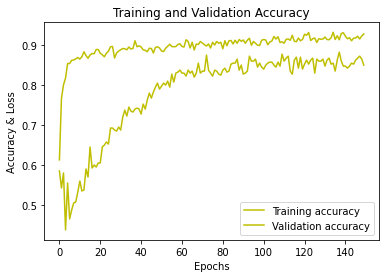

<Figure size 432x288 with 0 Axes>

In [19]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'y', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'y', label='Validation accuracy')

plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy & Loss")
plt.xlabel("Epochs")
plt.legend()
plt.savefig('/kaggle/working/train_val_acc.png', dpi=100)
plt.figure()

<Figure size 432x288 with 0 Axes>

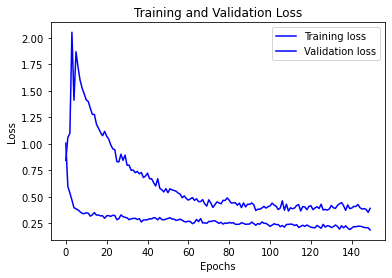

<Figure size 432x288 with 0 Axes>

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']


plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.savefig('/kaggle/working/train_val_loss.png', dpi=100)
plt.figure()

# Testing

In [21]:
print('Evaluating on testing data...')
test_loss, test_accuarcy, test_auc, test_precision, test_recall = model.evaluate(test_gen)

Evaluating on testing data...
10/10 [==============================] - 2s 151ms/step - loss: 0.8476 - accuracy: 0.7133 - auc: 0.8803 - precision: 0.7177 - recall: 0.7033


## Making Prediction

In [22]:
predictions = []

for filepath in tqdm(test_data['path']):
    im = cv2.imread(filepath)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = im/255.

    im = im.reshape((1, *INPUT_TENSOR))
    pred = model.predict(im)

    predictions.append(pred)

In [23]:
# predicted labels
predictions = np.squeeze(np.array(predictions))
predictions = np.argmax(predictions, axis = 1)

# True labels
true = test_gen.labels
true = (np.array(true))

In [24]:
predictions

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 1, 1, 2, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 2, 2, 0, 0, 0, 0, 0, 1, 1, 2, 1, 0, 0,
       0, 2, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 2, 2, 1, 0, 0, 1, 1, 1, 2, 0, 0, 0, 2, 0, 2, 2, 0,
       1, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 2, 1, 0, 2, 0, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 0, 2, 0, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 0, 1, 0, 1, 2, 2,
       1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 2, 2, 1, 2, 1, 0, 2, 0, 1, 2, 2, 0, 2, 2, 2, 2, 1,
       1, 0, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1])

In [25]:
true

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

## Confusion Matrix 

<Figure size 432x288 with 0 Axes>

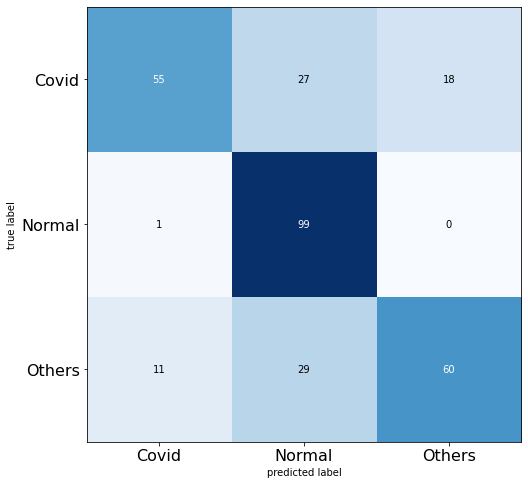

In [26]:
# Get the confusion matrix
cm  = confusion_matrix(true, predictions)

plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(3), ['Covid', 'Normal', 'Others'], fontsize=16)
plt.yticks(range(3), ['Covid', 'Normal', 'Others'], fontsize=16)
plt.savefig('/kaggle/working/confusion_matrix_EFFb7.png', dpi=100)
plt.show()

## Classification Report

In [27]:
report = classification_report(true, predictions, target_names = ['Normal', 'Covid', 'Others'])
print(report)

              precision    recall  f1-score   support

      Normal       0.82      0.55      0.66       100
       Covid       0.64      0.99      0.78       100
      Others       0.77      0.60      0.67       100

    accuracy                           0.71       300
   macro avg       0.74      0.71      0.70       300
weighted avg       0.74      0.71      0.70       300



## Sensitivity

In [28]:
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def sesitivity_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns

sesitivity_macro_average(cm)

0.7133333333333334

## Specificity

In [29]:
def specificity(label, confusion_matrix):
    neg_arr = np.delete(confusion_matrix, label, axis = 0)
    return np.delete(neg_arr, label, axis = 1).sum()/neg_arr.sum()

def specificity_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_specificities = 0
    for label in range(columns):
        sum_of_specificities += specificity(label, confusion_matrix)
    return sum_of_specificities / columns

specificity_macro_average(cm)

0.8566666666666666